In [ ]:
import numpy as np

# Carregar os dados
dados = np.load('/content/dados_emocoes_divididos.npz')

train_ids = dados['train_ids']
train_scores = dados['train_scores']
y_train = dados['y_train']
val_ids = dados['val_ids']
val_scores = dados['val_scores']
y_val = dados['y_val']
test_ids = dados['test_ids']
test_scores = dados['test_scores']
y_test = dados['y_test']

In [ ]:
import numpy as np
import itertools
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

# Hiperparâmetros
embedding_dims = [32]
num_heads_list = [4]
ff_dims = [64]
learning_rates = [0.001]
batch_size = 64
epochs = 100

max_len = train_ids.shape[1]
num_emotions = 8

resultados = []

def transformer_encoder_block(inputs, num_heads, ff_dim, embedding_dim):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(inputs, inputs)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ffn = Dense(ff_dim, activation='relu')(out1)
    ffn = Dense(embedding_dim)(ffn)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn)

# Loop de combinações
for embedding_dim, num_heads, ff_dim, lr in itertools.product(embedding_dims, num_heads_list, ff_dims, learning_rates):
    print(f"🔄 Transformer | Embedding={embedding_dim} | Heads={num_heads} | FF={ff_dim} | LR={lr}")

    input_ids = Input(shape=(max_len,), name='emotion_ids_input')
    x = Embedding(input_dim=num_emotions, output_dim=embedding_dim)(input_ids)
    x = transformer_encoder_block(x, num_heads=num_heads, ff_dim=ff_dim, embedding_dim=embedding_dim)
    x = GlobalAveragePooling1D()(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    nome_modelo = f"modelo_IDS_transformer_emb{embedding_dim}_head{num_heads}_ff{ff_dim}_lr{str(lr).replace('.', '')}.keras"

    checkpoint = ModelCheckpoint(
        filepath=nome_modelo,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=train_ids,
        y=y_train,
        class_weight={0: 1, 1: 2},
        validation_data=(val_ids, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop, checkpoint]
    )

    y_pred_probs = model.predict(val_ids)
    y_pred = (y_pred_probs > 0.5).astype(int)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    f1_fake = report.get('1', {}).get('f1-score', 0.0)

    print(f"💾 Modelo salvo: {nome_modelo}")
    print(f"✅ Resultado: Accuracy={acc:.4f} | F1-Fake={f1_fake:.4f}")

    resultados.append({
        'embedding_dim': embedding_dim,
        'num_heads': num_heads,
        'ff_dim': ff_dim,
        'learning_rate': lr,
        'accuracy': acc,
        'f1_fake': f1_fake,
        'model_file': nome_modelo
    })

# Salvar resultados
with open('resultados_transformer_encoder.pkl', 'wb') as f:
    pickle.dump(resultados, f)

# Top 5
resultados.sort(key=lambda x: x['f1_fake'], reverse=True)
print("\n🏆 Top 5 configurações por F1-Fake:")
for r in resultados[:5]:
    print(f"📂 {r['model_file']} | F1-Fake={r['f1_fake']:.4f} | Accuracy={r['accuracy']:.4f}")

🔄 Transformer | Embedding=32 | Heads=4 | FF=64 | LR=0.001
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step
💾 Modelo salvo: modelo_IDS_transformer_emb32_head4_ff64_lr0001.keras
✅ Resultado: Accuracy=0.6455 | F1-Fake=0.0000

🏆 Top 5 configurações por F1-Fake:
📂 modelo_IDS_transformer_emb32_head4_ff64_lr0001.keras | F1-Fake=0.0000 | Accuracy=0.6455


In [ ]:
# "LSTM (Top Accuracy)": "modelo_IDS_lstm256_batch128_emb16_lr0001.keras",
import numpy as np
import itertools
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Hiperparâmetros
unidades = [128]
batches = [32]
embeddings = [32]
learning_rates = [0.01]
epochs = 100

num_emotions = 8
max_len = train_ids.shape[1]

resultados = []


for lstm_units, batch_size, embedding_dim, lr in itertools.product(unidades, batches, embeddings, learning_rates):
    print(f"🔄 LSTM={lstm_units} | Batch={batch_size} | Embedding={embedding_dim} | LR={lr}")

    input_ids = Input(shape=(max_len,), name='emotion_ids_input')
    x = Embedding(input_dim=num_emotions, output_dim=embedding_dim, mask_zero=True)(input_ids)
    x = LSTM(lstm_units)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    nome_modelo = f"modelo_IDS_lstm{lstm_units}_batch{batch_size}_emb{embedding_dim}_lr{str(lr).replace('.', '')}.keras"

    checkpoint = ModelCheckpoint(
        filepath=nome_modelo,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=train_ids,
        y=y_train,
        class_weight={0: 1, 1: 2},
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_ids, y_val),
        verbose=0,
        callbacks=[early_stop, checkpoint]
    )

    y_pred_probs = model.predict(val_ids)
    y_pred = (y_pred_probs > 0.).astype(int)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    f1_fake = report.get('1', {}).get('f1-score', 0.0)

    print(f"💾 Modelo salvo: {nome_modelo}")
    print(f"✅ Resultado: Accuracy={acc:.4f} | F1-Fake={f1_fake:.4f}")

    resultados.append({
        'lstm_units': lstm_units,
        'batch_size': batch_size,
        'embedding_dim': embedding_dim,
        'learning_rate': lr,
        'accuracy': acc,
        'f1_fake': f1_fake,
        'model_file': nome_modelo
    })

# Salvar os resultados
with open('resultados_gridsearch_IDS2.pkl', 'wb') as f:
    pickle.dump(resultados, f)

# Mostrar os 5 melhores
resultados.sort(key=lambda x: x['f1_fake'], reverse=True)
print("\n -------------------------------------------------------------------------------------------------------------- \n")
print("\\n🏆 Top 5 configurações por F1-Fake:")
for r in resultados[:5]:
    print(f"📂 {r['model_file']} | F1-Fake={r['f1_fake']:.4f} | Accuracy={r['accuracy']:.4f}")

🔄 LSTM=128 | Batch=32 | Embedding=32 | LR=0.01
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
💾 Modelo salvo: modelo_IDS_lstm128_batch32_emb32_lr001.keras
✅ Resultado: Accuracy=0.4240 | F1-Fake=0.0000

 -------------------------------------------------------------------------------------------------------------- 

\n🏆 Top 5 configurações por F1-Fake:
📂 modelo_IDS_lstm128_batch32_emb32_lr001.keras | F1-Fake=0.0000 | Accuracy=0.4240


In [ ]:
# "LSTM (Top Accuracy)": "modelo_IDS_lstm256_batch128_emb16_lr0001.keras",
import numpy as np
import itertools
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Hiperparâmetros
unidades = [32]
batches = [64]
embeddings = [32]
learning_rates = [0.01]
epochs = 100

num_emotions = 8
max_len = train_ids.shape[1]

resultados = []


for lstm_units, batch_size, embedding_dim, lr in itertools.product(unidades, batches, embeddings, learning_rates):
    print(f"🔄 LSTM={lstm_units} | Batch={batch_size} | Embedding={embedding_dim} | LR={lr}")

    input_ids = Input(shape=(max_len,), name='emotion_ids_input')
    x = Embedding(input_dim=num_emotions, output_dim=embedding_dim, mask_zero=True)(input_ids)
    x = LSTM(lstm_units)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    nome_modelo = f"modelo_IDS_lstm{lstm_units}_batch{batch_size}_emb{embedding_dim}_lr{str(lr).replace('.', '')}.keras"

    checkpoint = ModelCheckpoint(
        filepath=nome_modelo,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=train_ids,
        y=y_train,
        class_weight={0: 1, 1: 2},
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_ids, y_val),
        verbose=0,
        callbacks=[early_stop, checkpoint]
    )

    y_pred_probs = model.predict(val_ids)
    y_pred = (y_pred_probs > 0.).astype(int)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    f1_fake = report.get('1', {}).get('f1-score', 0.0)

    print(f"💾 Modelo salvo: {nome_modelo}")
    print(f"✅ Resultado: Accuracy={acc:.4f} | F1-Fake={f1_fake:.4f}")

    resultados.append({
        'lstm_units': lstm_units,
        'batch_size': batch_size,
        'embedding_dim': embedding_dim,
        'learning_rate': lr,
        'accuracy': acc,
        'f1_fake': f1_fake,
        'model_file': nome_modelo
    })

# Salvar os resultados
with open('resultados_gridsearch_IDS2.pkl', 'wb') as f:
    pickle.dump(resultados, f)

# Mostrar os 5 melhores
resultados.sort(key=lambda x: x['f1_fake'], reverse=True)
print("\n -------------------------------------------------------------------------------------------------------------- \n")
print("\\n🏆 Top 5 configurações por F1-Fake:")
for r in resultados[:5]:
    print(f"📂 {r['model_file']} | F1-Fake={r['f1_fake']:.4f} | Accuracy={r['accuracy']:.4f}")

🔄 LSTM=32 | Batch=64 | Embedding=32 | LR=0.01
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
💾 Modelo salvo: modelo_IDS_lstm32_batch64_emb32_lr001.keras
✅ Resultado: Accuracy=0.4240 | F1-Fake=0.0000

 -------------------------------------------------------------------------------------------------------------- 

\n🏆 Top 5 configurações por F1-Fake:
📂 modelo_IDS_lstm32_batch64_emb32_lr001.keras | F1-Fake=0.0000 | Accuracy=0.4240


In [ ]:
# "BiLSTM (Top F1)": "modelo_IDS_bilstm128_batch32_emb32_lr00025.keras",
import numpy as np
import itertools
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Hiperparâmetros
unidades = [128]
batches = [32]
embeddings = [32]
learning_rates = [0.0025]
epochs = 100

num_emotions = 8
max_len = train_ids.shape[1]

resultados = []

for lstm_units, batch_size, embedding_dim, lr in itertools.product(unidades, batches, embeddings, learning_rates):
    print(f"🔄 BiLSTM={lstm_units} | Batch={batch_size} | Embedding={embedding_dim} | LR={lr}")

    input_ids = Input(shape=(max_len,), name='emotion_ids_input')
    x = Embedding(input_dim=num_emotions, output_dim=embedding_dim, mask_zero=True)(input_ids)
    x = Bidirectional(LSTM(lstm_units))(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    nome_modelo = f"modelo_IDS_bilstm{lstm_units}_batch{batch_size}_emb{embedding_dim}_lr{str(lr).replace('.', '')}.keras"

    checkpoint = ModelCheckpoint(
        filepath=nome_modelo,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=train_ids,
        y=y_train,
        class_weight={0: 1, 1: 2},
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_ids, y_val),
        verbose=0,
        callbacks=[early_stop, checkpoint]
    )

    y_pred_probs = model.predict(val_ids)
    y_pred = (y_pred_probs > 0.5).astype(int)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    f1_fake = report.get('1', {}).get('f1-score', 0.0)

    print(f"💾 Modelo salvo: {nome_modelo}")
    print(f"✅ Resultado: Accuracy={acc:.4f} | F1-Fake={f1_fake:.4f}")

    resultados.append({
        'lstm_units': lstm_units,
        'batch_size': batch_size,
        'embedding_dim': embedding_dim,
        'learning_rate': lr,
        'accuracy': acc,
        'f1_fake': f1_fake,
        'model_file': nome_modelo
    })

# Salvar os resultados
with open('resultados_gridsearch_BiLSTM128_com_lr.pkl', 'wb') as f:
    pickle.dump(resultados, f)

# Mostrar os 5 melhores
resultados.sort(key=lambda x: x['f1_fake'], reverse=True)
print("\\n🏆 Top 5 configurações por F1-Fake:")
for r in resultados[:5]:
    print(f"📂 {r['model_file']} | F1-Fake={r['f1_fake']:.4f} | Accuracy={r['accuracy']:.4f}")

🔄 BiLSTM=128 | Batch=32 | Embedding=32 | LR=0.0025
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
💾 Modelo salvo: modelo_IDS_bilstm128_batch32_emb32_lr00025.keras
✅ Resultado: Accuracy=0.6321 | F1-Fake=0.0000
\n🏆 Top 5 configurações por F1-Fake:
📂 modelo_IDS_bilstm128_batch32_emb32_lr00025.keras | F1-Fake=0.0000 | Accuracy=0.6321


In [ ]:
# "CNN+LSTM (Top Recall)": "modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr00025.keras",
import numpy as np
import itertools
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Hiperparâmetros
unidades = [64]
batches = [256]
embeddings = [32]
learning_rates = [0.0025]
kernel_sizes = [3, 4, 5]
epochs = 100

num_emotions = 8
max_len = train_ids.shape[1]

resultados = []

for lstm_units, batch_size, embedding_dim, lr in itertools.product(unidades, batches, embeddings, learning_rates):
    print(f"🔄 CNN+LSTM | Batch={batch_size} | Embedding={embedding_dim} | LSTM Units={lstm_units} | LR={lr}")

    input_ids = Input(shape=(max_len,), name='emotion_ids_input')
    x = Embedding(input_dim=num_emotions, output_dim=embedding_dim, mask_zero=True)(input_ids)

    convs = []
    for k in kernel_sizes:
        c = Conv1D(filters=64, kernel_size=k, activation='relu', padding='same')(x)
        p = MaxPooling1D(pool_size=2)(c)
        convs.append(p)

    x = Concatenate(axis=-1)(convs)
    x = LSTM(lstm_units)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    nome_modelo = f"modelo_IDS_cnnmultik_lstm{lstm_units}_batch{batch_size}_emb{embedding_dim}_lr{str(lr).replace('.', '')}_kernel{k}.keras"

    checkpoint = ModelCheckpoint(
        filepath=nome_modelo,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=train_ids,
        y=y_train,
        class_weight={0: 1, 1: 2},
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_ids, y_val),
        verbose=0,
        callbacks=[early_stop, checkpoint]
    )

    y_pred_probs = model.predict(val_ids)
    y_pred = (y_pred_probs > 0.5).astype(int)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    f1_fake = report.get('1', {}).get('f1-score', 0.0)

    print(f"💾 Modelo salvo: {nome_modelo}")
    print(f"✅ Resultado: Accuracy={acc:.4f} | F1-Fake={f1_fake:.4f}")

    resultados.append({
        'lstm_units': lstm_units,
        'batch_size': batch_size,
        'embedding_dim': embedding_dim,
        'learning_rate': lr,
        'accuracy': acc,
        'f1_fake': f1_fake,
        'model_file': nome_modelo
    })

# Salvar os resultados
with open('resultados_gridsearch_CNN_MultiKernel_LSTM.pkl', 'wb') as f:
    pickle.dump(resultados, f)

# Mostrar os 5 melhores
resultados.sort(key=lambda x: x['f1_fake'], reverse=True)
print("\\n🏆 Top 5 configurações por F1-Fake:")
for r in resultados[:5]:
    print(f"📂 {r['model_file']} | F1-Fake={r['f1_fake']:.4f} | Accuracy={r['accuracy']:.4f}")

🔄 CNN+LSTM | Batch=256 | Embedding=32 | LSTM Units=64 | LR=0.0025


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
💾 Modelo salvo: modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr00025_kernel5.keras
✅ Resultado: Accuracy=0.6182 | F1-Fake=0.0000
\n🏆 Top 5 configurações por F1-Fake:
📂 modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr00025_kernel5.keras | F1-Fake=0.0000 | Accuracy=0.6182


In [ ]:
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def avaliar_modelos_keras(start, diretorio, x_val, y_val):
    resultados = []

    for nome_arquivo in os.listdir(diretorio):
        if nome_arquivo.startswith(start) and nome_arquivo.endswith(".keras"):
            caminho = os.path.join(diretorio, nome_arquivo)
            print(f"🔄 Avaliando {caminho}...")

            try:
                modelo = load_model(caminho)
                y_pred_probs = modelo.predict(x_val)
                y_pred = (y_pred_probs > 0.5).astype(int)

                print(f"Metricas - {nome_arquivo}")

                precisao = precision_score(y_val, y_pred, zero_division=0)
                recall = recall_score(y_val, y_pred, zero_division=0)
                f1 = f1_score(y_val, y_pred, zero_division=0)
                acc = accuracy_score(y_val, y_pred)
                matriz = confusion_matrix(y_val, y_pred)
                print (f"Confusion Matrix:\n{matriz}")
                print(f"Precision: {precisao:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f} - Accuracy: {acc:.4f}")
                print("--------------------------------------------------------------------------------------------------------------")

                metricas = {
                    "accuracy": acc,
                    "precision": precisao,
                    "recall": recall,
                    "f1_score": f1,
                    "confusion_matrix": matriz
                }

                resultados.append((caminho, metricas))
            except Exception as e:
                print(f"❌ Erro ao avaliar {caminho}: {e}")

    return resultados

In [ ]:
resultados_novos = avaliar_modelos_keras(
    start = 'modelo',
    diretorio=r'/content',
    x_val= val_ids,
    y_val=y_val
)

🔄 Avaliando /content/modelo_IDS_lstm32_batch64_emb32_lr001.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Metricas - modelo_IDS_lstm32_batch64_emb32_lr001.keras
Confusion Matrix:
[[4508 2831]
 [1835 3568]]
Precision: 0.5576 - Recall: 0.6604 - F1 Score: 0.6046 - Accuracy: 0.6338
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando /content/modelo_IDS_lstm256_batch128_emb16_lr0001.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Metricas - modelo_IDS_lstm256_batch128_emb16_lr0001.keras
Confusion Matrix:
[[4027 3312]
 [1447 3956]]
Precision: 0.5443 - Recall: 0.7322 - F1 Score: 0.6244 - Accuracy: 0.6265
--------------------------------------------------------------------------------------------------------------
🔄 Avaliando /content/modelo_IDS_bilstm128_batch32_emb32_lr00025.keras...
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Metricas - modelo_IDS_bilstm128_batch32_emb32_lr00025.keras
Confusion Matrix:
[[4393 2946]
 [1

399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

🔍 LSTM  - Relatório com Threshold Ajustado (0.4375):
              precision    recall  f1-score   support

    reliable       0.75      0.46      0.57      7339
        fake       0.52      0.79      0.63      5403

    accuracy                           0.60     12742
   macro avg       0.63      0.63      0.60     12742
weighted avg       0.65      0.60      0.59     12742

399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

🔍 BiLSTM  - Relatório com Threshold Ajustado (0.3889):
              precision    recall  f1-score   support

    reliable       0.75      0.38      0.50      7339
        fake       0.49      0.82      0.62      5403

    accuracy                           0.57     12742
   macro avg       0.62      0.60      0.56     12742
weighted avg       0.64      0.57      0.55     12742



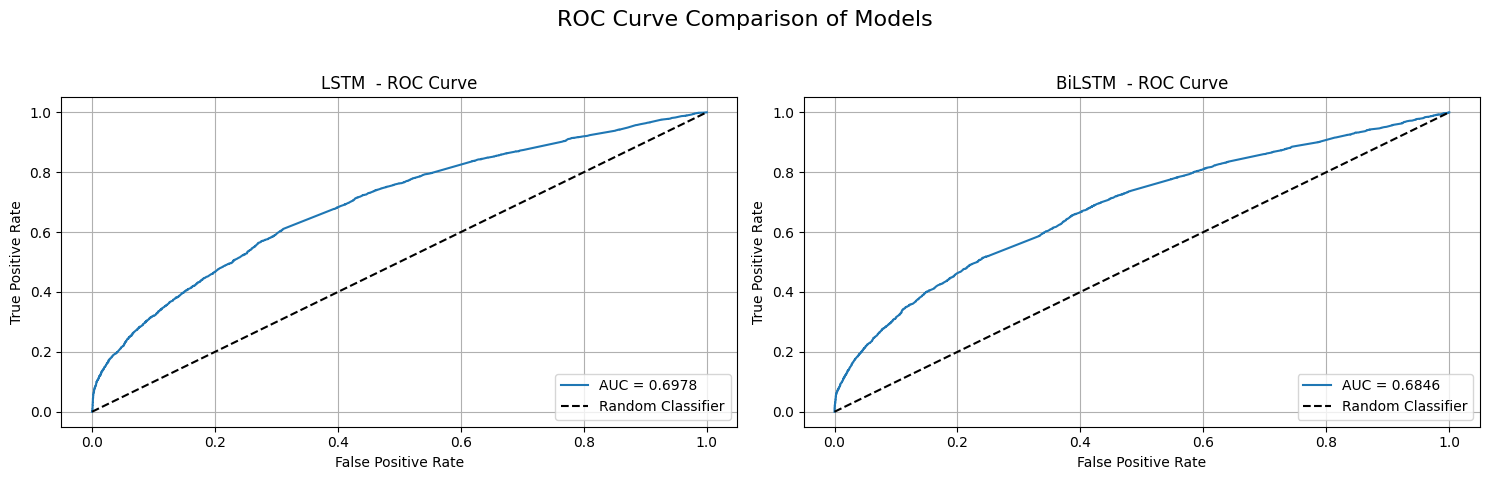

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, classification_report, precision_recall_curve

# ================== 1. LISTA DE MODELOS (ATUALIZE COM SEUS CAMINHOS!) ==================
model_paths = {
    "LSTM ": "modelo_IDS_lstm256_batch128_emb16_lr0001.keras",
    "BiLSTM ": "modelo_IDS_bilstm128_batch32_emb32_lr00025.keras",
    # "CNN+LSTM (Top Recall)": "modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr00025_kernel5.keras",
    # Adicione outros se quiser!
}

# ================== 2. CARREGAR DADOS (SUBSTITUA COM SEUS DADOS!) ==================
# X_test: dados de teste (shape [amostras, features])
# y_true: rótulos reais (0 = reliable, 1 = fake)
X_test = test_ids
y_true = y_test

# ================== 3. CALCULAR PROBABILIDADES E PLOTAR ROC ==================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, (model_name, path) in zip(axes, model_paths.items()):
    # Carregar modelo
    model = load_model(path)

    # Obter probabilidades da classe "fake" (1)
    y_probs = model.predict(X_test).flatten()  # Correto para saída única!

    # Calcular ROC e AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # # Plotar curva ROC
    # RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name).plot()
    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    ax.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    ax.set_title(f"{model_name} - ROC Curve", fontsize=12)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

    # (Opcional) Ajustar threshold para máximo F1-score
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_threshold = thresholds_pr[np.argmax(f1_scores)]

    # Gerar relatório com threshold ajustado
    y_pred_ajustado = (y_probs >= best_threshold).astype(int)
    print(f"\n🔍 {model_name} - Relatório com Threshold Ajustado ({best_threshold:.4f}):")
    print(classification_report(y_true, y_pred_ajustado, target_names=["reliable", "fake"]))


plt.suptitle("ROC Curve Comparison of Models", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Carregue o melhor modelo de cada categoria
models = {
    "LSTM": load_model("modelo_IDS_lstm256_batch128_emb16_lr0001.keras"),
    "CNN+LSTM": load_model("modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr00025_kernel5.keras"),
    "BiLSTM": load_model("modelo_IDS_bilstm128_batch32_emb32_lr00025.keras")
}

# Avalie cada um no TESTE
for name, model in models.items():
    y_probs = model.predict(X_test).flatten()
    y_pred = (y_probs >= 0.5).astype(int)  # Threshold padrão
    print(f"\n🔍 {name} - Teste:")
    print(classification_report(y_test, y_pred, target_names=["reliable", "fake"]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

🔍 LSTM - Teste:
              precision    recall  f1-score   support

    reliable       0.73      0.55      0.63      7339
        fake       0.54      0.73      0.62      5403

    accuracy                           0.63     12742
   macro avg       0.64      0.64      0.63     12742
weighted avg       0.65      0.63      0.63     12742

 17/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step    

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

🔍 CNN+LSTM - Teste:
              precision    recall  f1-score   support

    reliable       0.71      0.65      0.68      7339
        fake       0.58      0.64      0.61      5403

    accuracy                           0.65     12742
   macro avg       0.64      0.65      0.64     12742
weighted avg       0.65      0.65      0.65     12742

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

🔍 BiLSTM - Teste:
              precision    recall  f1-score   support

    reliable       0.71      0.60      0.65      7339
        fake       0.55      0.67      0.60      5403

    accuracy                           0.63     12742
   macro avg       0.63      0.63      0.63     12742
weighted avg       0.64      0.63      0.63     12742



399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

🔍 LSTM - Relatório com Threshold Ajustado (0.4375):
              precision    recall  f1-score   support

    reliable       0.75      0.46      0.57      7339
        fake       0.52      0.79      0.63      5403

    accuracy                           0.60     12742
   macro avg       0.63      0.63      0.60     12742
weighted avg       0.65      0.60      0.59     12742

399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

🔍 BiLSTM - Relatório com Threshold Ajustado (0.3889):
              precision    recall  f1-score   support

    reliable       0.75      0.38      0.50      7339
        fake       0.49      0.82      0.62      5403

    accuracy                           0.57     12742
   macro avg       0.62      0.60      0.56     12742
weighted avg       0.64      0.57      0.55     12742



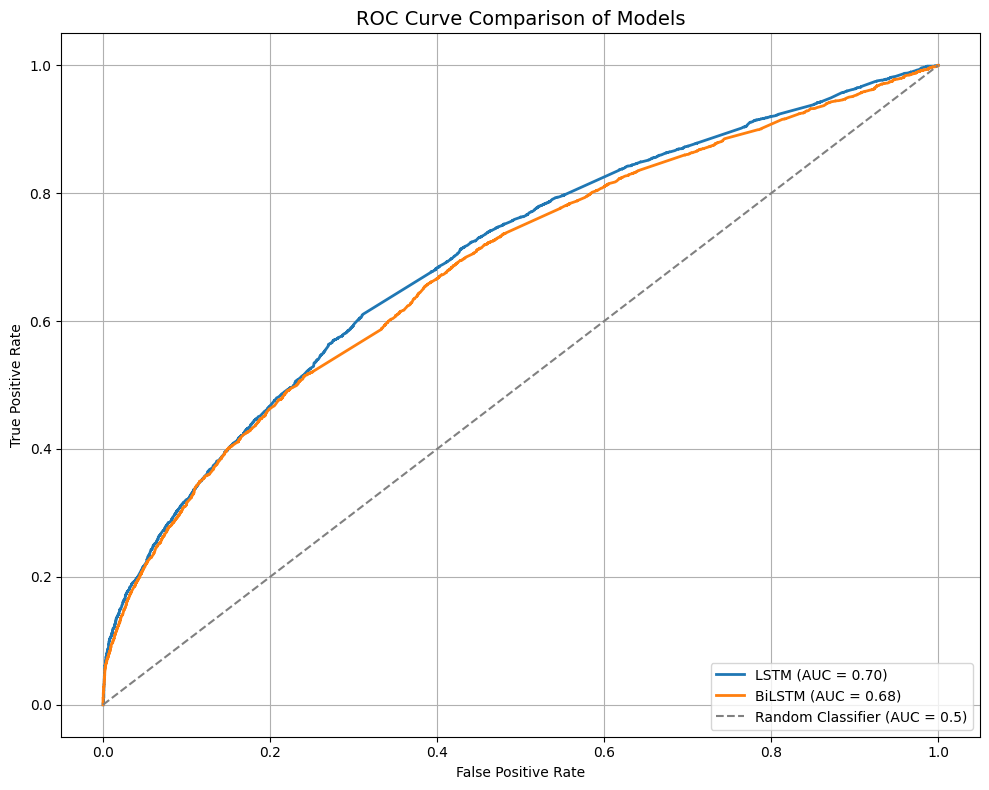

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve

# ========== MODELOS ==========
model_paths = {
    "LSTM": "modelo_IDS_lstm256_batch128_emb16_lr0001.keras",
    "BiLSTM": "modelo_IDS_bilstm128_batch32_emb32_lr00025.keras"
    # "CNN+LSTM (Top Recall)": "modelo_IDS_cnnmultik_lstm64_batch256_emb32_lr00025_kernel5.keras",
    # "Transformer (Best)": "modelo_IDS_transformer_emb32_head4_ff64_lr0001.keras"
}

# ========== DADOS ==========
X_test = test_ids
y_true = y_test

# ========== PLOT ==========
plt.figure(figsize=(10, 8))

for model_name, path in model_paths.items():
    model = load_model(path)
    y_probs = model.predict(X_test).flatten()

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

    # (Opcional) Threshold ideal para F1
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_threshold = thresholds_pr[np.argmax(f1_scores)]
    y_pred_ajustado = (y_probs >= best_threshold).astype(int)
    print(f"\n🔍 {model_name} - Relatório com Threshold Ajustado ({best_threshold:.4f}):")
    print(classification_report(y_true, y_pred_ajustado, target_names=["reliable", "fake"]))

# Linha aleatória
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier (AUC = 0.5)")

plt.title("ROC Curve Comparison of Models", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
